In [16]:
import requests
import io
from bs4 import BeautifulSoup as BS
import pandas as pd
import sys
import time
from datetime import date,datetime,timedelta
import random
import numpy as np
from PIL import Image as IM
import pytesseract
import os
import cv2
import re
import asyncio
import hangups
from scipy.misc import toimage
from sklearn import preprocessing
from IPython.display import display

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.utils import np_utils

Using Theano backend.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
class captcha_recognize:
    def __init__(self):
        self.model = None
        self.lable = ['2', '3', '4', '6', '7', '8', '9', 'A', 'C', 'D', 'E', 'F', 'G','H', 'J', 
                      'K', 'L', 'N', 'P', 'Q', 'R', 'T', 'U', 'V', 'X', 'Y', 'Z']
    def one_hot_reverse(self,onehot):
        return self.lable[np.where(onehot==1)[0][0]]
    def load_model(self):
        self.model = model_from_json(open('cnn_captcha.json').read())
        self.model.load_weights('TWSE_captcha_weights.h5')

        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])
    def preprocess(self,image):
        X = []
        imgpos = [[5,45],[45,85],[85,125],[125,165],[160,200]]
        #image = IM.open('/home/ubuntu/Notebooks/captest.png')
        imgarray = np.asarray(image)
        for tid in range(5):
            X.append(imgarray[10:50,imgpos[tid][0]:imgpos[tid][1]].reshape(3,40,40))
        X = np.array(X).astype('float32')
        X /= 255
        return X
    
    def captcha_predict(self,X):
        if type(self.model)!= Sequential:
            self.load_model()
        ans = self.model.predict(X)
        captcha =''
        for i in ans:
            captcha += self.lable[i.argmax()]
        return captcha

In [54]:
refpath = ''#os.getcwd()+'/'
CONVERSATION_ID = 'Ugx10p7pgNA_uogOqn54AaABAagB3ZWGCA'
REFRESH_TOKEN_PATH = refpath+'refresh_token.txt'
    
def Hangouts():
    cookies = hangups.auth.get_auth_stdin(REFRESH_TOKEN_PATH)
    client = hangups.Client(cookies)
    client.on_connect.add_observer(lambda: asyncio.async(send_message(client)))
    loop = asyncio.get_event_loop()
    loop.run_until_complete(client.connect())
@asyncio.coroutine
def send_message(client):
    """Send message using connected hangups.Client instance."""
    request = hangups.hangouts_pb2.SendChatMessageRequest(
        request_header=client.get_request_header(),
        event_request_header=hangups.hangouts_pb2.EventRequestHeader(
            conversation_id=hangups.hangouts_pb2.ConversationId(id=CONVERSATION_ID),
            client_generated_id=client.get_client_generated_id(),),
        message_content=hangups.hangouts_pb2.MessageContent(
            segment=[hangups.ChatMessageSegment(MESSAGE).serialize()],),)
    try:
        yield from client.send_chat_message(request)
    finally:
        yield from client.disconnect()

In [63]:
def transdate(l):
    l = l.split('/')
    return date(int(l[0]),int(l[1]),int(l[2]))
def transnum(l):
    return float(('').join(l.split(',')))
def divexpectz(a,b):
    if b == 0:
        return 0
    else:
        return round(a/b,2)
def returnstat(id0,reposttime):
    text = "\r {0}重新取得驗證碼次數:{1}".format(id0,reposttime)
    sys.stdout.write(text)
    sys.stdout.flush()

class TWSEBSreport:
    def __init__(self):
        self.urltwse = 'http://bsr.twse.com.tw/bshtm/'
        self.rs = requests.session()
        self.curpath = ''
        self.datenow = self.__getdate()
        self.notradedata = []#new
        stockidt = pd.read_csv('csv_data/listcompanym.csv',encoding='utf-8')
        self.stockidL = stockidt['股票代號'].tolist()
        self.captcha_rec = captcha_recognize()
        
    def __getdate(self):
        d = datetime.now()
        if d.hour<16:
            d = d.date() - timedelta(1)
        if type(d) != type(date.today()):
                d = d.date()
        if d.isoweekday() == 7:
            d = d - timedelta(2)
        elif d.isoweekday() == 6:
            d = d - timedelta(1)
        return d
    def getCaptcha(self):
        r1 = self.rs.get('http://bsr.twse.com.tw/bshtm/bsMenu.aspx')
        r1.encoding = 'utf-8'
        soup = BS(r1.text,'lxml')
        guid = soup.findAll('img')[1].attrs['src']
        self.VIEWSTATE = soup.select('#__VIEWSTATE')[0].attrs['value']
        self.EVENTVALIDATION = soup.select('#__EVENTVALIDATION')[0].attrs['value']
        captcha = self.rs.get('http://bsr.twse.com.tw/bshtm/%s'%guid, stream=True, verify=False)
        return captcha.content

    def OCR(self):
        image_array = IM.open(io.BytesIO(self.getCaptcha()))
        #display(image_array)
        return self.captcha_rec.captcha_predict(self.captcha_rec.preprocess(image_array))

    def postpayload(self,stock_id,captcha,sleeptime):
        payload ={'__EVENTTARGET':'',
                '__EVENTARGUMENT':'',
                '__LASTFOCUS':'',
                '__VIEWSTATE':'%s'%self.VIEWSTATE,
                '__EVENTVALIDATION':'%s'%self.EVENTVALIDATION,
                'RadioButton_Normal':'RadioButton_Normal',
                'TextBox_Stkno':'%s'%str(stock_id),
                'CaptchaControl1':'%s'%captcha,
                'btnOK':'查詢'}
        resp = self.rs.post('http://bsr.twse.com.tw/bshtm/bsMenu.aspx',data = payload)
        checkans = BS(resp.text,'lxml')
        self.answ = checkans.select('.radio')[3].text
        correctanswer = 0
        if self.answ =='':
            correctanswer = 1
            resq = self.rs.get('http://bsr.twse.com.tw/bshtm/bsContent.aspx?v=t')
            self.soupdata = BS(resq.text,"lxml")
        elif self.answ =='驗證碼錯誤!' or self.answ =='驗證碼已逾期.':
            correctanswer = 0
            time.sleep(sleeptime)
        elif self.answ =='查無資料':
            correctanswer = 2
        else:
            correctanswer = 0
            time.sleep(sleeptime)
        return correctanswer
    def processdata(self,stock_id):
        dat = transdate(self.soupdata.select('#receive_date')[0].text.strip('\r\n '))
        tda = transnum(self.soupdata.select('#trade_rec')[0].text.strip('\r\n '))
        ap = transnum(self.soupdata.select('#trade_amt')[0].text.strip('\r\n '))
        allshare = transnum(self.soupdata.select('#trade_qty')[0].text.strip('\r\n '))
        op = transnum(self.soupdata.select('#open_price')[0].text.strip('\r\n '))
        hp = transnum(self.soupdata.select('#high_price')[0].text.strip('\r\n '))
        lp = transnum(self.soupdata.select('#low_price')[0].text.strip('\r\n '))
        cp = transnum(self.soupdata.select('#last_price')[0].text.strip('\r\n '))
        d = {"日期":dat,"代號":stock_id,"成交筆數":tda,"總成交金額":ap,"總成交股數":allshare,
            "開盤價":op,"最高價":hp,"最低價":lp,"收盤價":cp}
        ind = pd.DataFrame(d, index=[1])
        ind.index.name = '序'
        dlist = pd.read_html(str(self.soupdata.select('#table2 table')), header=0, index_col=0)
        table = pd.DataFrame()
        for i in dlist:
            frames = [table, i]
            table = pd.concat(frames)
        table = table.dropna()
        table = table.join(ind)
        table[["日期","代號","成交筆數","總成交金額","總成交股數","開盤價","最高價","最低價","收盤價"]] = table[["日期","代號","成交筆數","總成交金額","總成交股數","開盤價","最高價","最低價","收盤價"]].fillna(method='pad')
        table = table[["日期","代號","成交筆數","總成交金額","總成交股數","開盤價","最高價","最低價","收盤價","證券商","成交單價","買進股數","賣出股數"]]
        table = table.sort_index()
        table['證券商']=table['證券商'].map(lambda x: str(x)[0:4])
        table['日期'] = pd.to_datetime(table['日期'])
        filename = str(stock_id)+"_"+('').join(str(dat).split('-'))
        table.to_csv(self.curpath+'csv_data/stockdt/ori/%s.csv'%filename)
        
        buyp = table.apply(lambda row: row['成交單價']*row['買進股數'],axis=1)
        table.insert(13,'買進金額',buyp)
        sellp = table.apply(lambda row: row['成交單價']*row['賣出股數'],axis=1)
        table.insert(14,'賣出金額',sellp)
        table_sort = table.groupby(["日期","代號","成交筆數","總成交金額","總成交股數","開盤價","最高價","最低價","收盤價","證券商"])[['買進股數','賣出股數','買進金額','賣出金額']].sum()
        table_sort = table_sort.reset_index(["成交筆數","總成交金額","總成交股數","開盤價","最高價","最低價","收盤價"])
        table_sort = table_sort[['買進股數','賣出股數','買進金額','賣出金額',"成交筆數","總成交金額","總成交股數","開盤價","最高價","最低價","收盤價"]]
        b_avg_p = table_sort.apply(lambda row: divexpectz(row['買進金額'],row['買進股數']),axis=1)
        s_avg_p = table_sort.apply(lambda row: divexpectz(row['賣出金額'],row['賣出股數']),axis=1)

        b_ratio = table_sort.apply(lambda row: divexpectz(row['買進股數'],row['總成交股數'])*100,axis=1)
        s_ratio = table_sort.apply(lambda row: divexpectz(row['賣出股數'],row['總成交股數'])*100,axis=1)

        bs_share_net = table_sort.apply(lambda row: row['買進股數']-row['賣出股數'],axis=1)
        bs_price_net = table_sort.apply(lambda row: row['買進金額']-row['賣出金額'],axis=1)
        table_sort.insert(2,'買賣超股數',bs_share_net)
        table_sort.insert(5,'買賣超金額',bs_price_net)
        table_sort.insert(6,'買進均價',b_avg_p)
        table_sort.insert(7,'賣出均價',s_avg_p)
        table_sort.insert(8,'買進比重',b_ratio)
        table_sort.insert(9,'賣出比重',s_ratio)
        if os.path.exists(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stock_id)) == False:
            table_sort.to_csv(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stock_id))
        #after first time use
        table_s = pd.read_csv(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stock_id),encoding='utf-8',index_col=[0,1,2],parse_dates=[0])
        if dat not in table_s.index.levels[0]:
            frame = [table_sort,table_s]
            table_s = pd.concat(frame)

        table_s.to_csv(self.curpath+'csv_data/stockdt/sort/%s.csv'%str(stock_id))
    def singleprocess(self,stockid):
        anscor = 0
        repostcount = 0
        filename = str(stockid)+"_"+('').join(str(self.__getdate()).split('-'))
        if os.path.exists(self.curpath+'csv_data/stockdt/ori/%s.csv'%filename) == False:
            while anscor==0:
                Capt = ''
                while len(Capt) !=5:
                    try:
                        Capt = self.OCR()
                    except:
                        pass
                anscor = self.postpayload(stockid, Capt, sleeptime=5)
                returnstat(stockid,repostcount)
                repostcount +=1
                if anscor == 2:
                        self.notradedata.append(stockid)
                        break
                if repostcount>150:
                    repostcount = 150
                    break
                time.sleep(random.choice([2.8,3.2,3.8,4.1,4.7]))
                if anscor == 1 :
                    self.processdata(stockid)
        elif os.path.exists(self.curpath+'csv_data/stockdt/ori/%s.csv'%filename) == True:
            repostcount = 100
        return stockid,repostcount
    def processAll(self):
        starttime = datetime.now()
        stlen = len(self.stockidL)
        self.arrcu = []
        global MESSAGE
        MESSAGE = ''
        for i in range(stlen):
            a = self.singleprocess(self.stockidL[i])
            if a[1]==150:
                a = self.singleprocess(self.stockidL[i])
            ptime = datetime.now()
            text = "\r上市 {0}/{1} 已完成 {2}%  處理時間: {3}".format(i+1,stlen,round((i+1)/stlen,4)*100,str(ptime-starttime))
            sys.stdout.write(text)
            sys.stdout.flush()
            #MESSAGE = "上市 {0}/{1} 已完成 {2}%  處理時間: {3}".format(i+1,stlen,round((i+1)/stlen,4)*100,str(ptime-starttime))
            #Hangouts()
            self.arrcu.append(a)
            if self.arrcu[-1][1] == 0:
                time.sleep(3)
            if len(self.arrcu)>3 and self.arrcu[-1][1] == 1 and self.arrcu[-2][1] == 1 and self.arrcu[-3][1] == 1:
                time.sleep(5)
        endtime = datetime.now()
        spendt = str(endtime - starttime)
        MESSAGE = "上市股票交易日報下載完成 \n 花費時間:{0}".format(spendt)
        Hangouts()
        

ERROR:asyncio:Unclosed response
client_response: <ClientResponse(https://0.client-channel.google.com/client-channel/channel/bind?gsessionid=D_TOj3qP-QEikcz9qVCLoJd7pqzQCoQG&t=1&CI=0&TYPE=xmlhttp&VER=8&RID=rpc&ctype=hangouts&SID=2B02BBF69405F179) [200 OK]>
<CIMultiDictProxy {'CACHE-CONTROL': 'no-cache, no-store, max-age=0, must-revalidate', 'PRAGMA': 'no-cache', 'EXPIRES': 'Mon, 01 Jan 1990 00:00:00 GMT', 'DATE': 'Mon, 27 Jun 2016 15:29:09 GMT', 'CONTENT-TYPE': 'text/plain; charset=utf-8', 'TRANSFER-ENCODING': 'chunked', 'X-CONTENT-TYPE-OPTIONS': 'nosniff', 'X-XSS-PROTECTION': '1; mode=block', 'SERVER': 'GSE', 'ALTERNATE-PROTOCOL': '443:quic', 'ALT-SVC': 'quic=":443"; ma=2592000; v="34,33,32,31,30,29,28,27,26,25"'}>

ERROR:asyncio:Unclosed response
client_response: <ClientResponse(https://0.client-channel.google.com/client-channel/channel/bind?gsessionid=WyQ8FlwEJEII5z4UiZC5KeYgqpGDK7Em&t=1&CI=0&TYPE=xmlhttp&VER=8&RID=rpc&ctype=hangouts&SID=66DC4DC4FA9E6B98) [200 OK]>
<CIMultiDictProxy 

In [64]:
BSr = TWSEBSreport()

In [53]:
BSr.singleprocess(2332)

 2332重新取得驗證碼次數:0

(2332, 1)

In [57]:
BSr.OCR()

'REPGC'

In [65]:
BSr.processAll()

 2030重新取得驗證碼次數:0

KeyboardInterrupt: 

In [59]:
BSr.arrcu

[(1101, 1),
 (1102, 1),
 (1103, 1),
 (1104, 1),
 (1108, 1),
 (1109, 1),
 (1110, 1),
 (1201, 1),
 (1203, 1),
 (1210, 1),
 (1213, 1),
 (1215, 1),
 (1216, 1),
 (1217, 1),
 (1218, 1),
 (1219, 1),
 (1220, 1),
 (1225, 1),
 (1227, 1),
 (1229, 1),
 (1231, 1),
 (1232, 1),
 (1233, 1),
 (1234, 1),
 (1235, 1),
 (1236, 1),
 (1262, 1),
 (1301, 1),
 (1303, 1),
 (1304, 2),
 (1305, 1),
 (1307, 1),
 (1308, 1),
 (1309, 1),
 (1310, 1),
 (1312, 1),
 (1313, 1),
 (1314, 1),
 (1315, 1),
 (1316, 1),
 (1319, 1),
 (1321, 1),
 (1323, 1),
 (1324, 1),
 (1325, 1),
 (1326, 1),
 (1337, 1),
 (1338, 1),
 (1339, 1),
 (1340, 1),
 (1402, 1),
 (1409, 1),
 (1410, 1),
 (1413, 1),
 (1414, 1),
 (1416, 1),
 (1417, 1),
 (1418, 1),
 (1419, 1),
 (1423, 1),
 (1432, 1),
 (1434, 1),
 (1435, 1),
 (1436, 1),
 (1437, 1),
 (1438, 1),
 (1439, 1),
 (1440, 1),
 (1441, 1),
 (1442, 1),
 (1443, 1),
 (1444, 1),
 (1445, 1),
 (1446, 1),
 (1447, 1),
 (1449, 1),
 (1451, 1),
 (1452, 1),
 (1453, 1),
 (1454, 1),
 (1455, 1),
 (1456, 1),
 (1457, 1),
 (14

In [138]:
if 'O' replace 'Q'
if '1' replace 'T'#'L'
if 'S' replace '3','8','6'
if '5' replace 'E'
if 'I' replace '7'# appear more than 3 time
if '0' replace 'Q'
if 'B' replace '8'
'BIOSW150'

SyntaxError: invalid syntax (<ipython-input-138-d72e1fb9d4dd>, line 1)

In [53]:
BSr.postpayload(2330,BSr.OCR())

'驗證碼已逾期.'

In [7]:
rs = requests.session()
r1 = rs.get('http://bsr.twse.com.tw/bshtm/bsMenu.aspx')
r1.encoding = 'utf-8'
soup = BS(r1.text,'lxml')
guid = soup.findAll('img')[1].attrs['src']

In [8]:
captcha = rs.get('http://bsr.twse.com.tw/bshtm/%s'%guid, stream=True, verify=False)

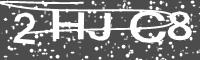

In [9]:
Image(io.BytesIO(captcha.content).getvalue(), format='jpeg')

In [14]:
VIEWSTATE = soup.select('#__VIEWSTATE')[0].attrs['value']
EVENTVALIDATION = soup.select('#__EVENTVALIDATION')[0].attrs['value']

In [16]:
EVENTVALIDATION

'/wEdAAYIeYuZGmqJB+44TTP6z4nmfMmuxAJNAJcNkRRsVeJwwqKURZav/+YrVMqaWE2hvMxJwK4Ohf3nRgXHkFhQen1PRSciNdPYWmINCrip1wqw01PJCA0uL9aE2sjICZqv6GoCAa3R/zDj7qnkpY/Z/3Di'

In [ ]:
rs = requests.session()
r1 = rs.get('http://bsr.twse.com.tw/bshtm/bsMenu.aspx')
r1.encoding = 'utf-8'
soup = BS(r1.text,'lxml')
guid = soup.findAll('img')[1].attrs['src']
VIEWSTATE = soup.select('#__VIEWSTATE')[0].attrs['value']
EVENTVALIDATION = soup.select('#__EVENTVALIDATION')[0].attrs['value']
captcha = rs.get('http://bsr.twse.com.tw/bshtm/%s'%guid, stream=True, verify=False)
Image(io.BytesIO(captcha.content).getvalue(), format='jpeg')